# Analisi delle componenti principali sul dataset sintetico 2

## Generazione del dataset sintetico

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# Abilita la visualizzazione dei grafici all'interno del notebook.
%matplotlib inline

# Imposta alcuni parametri per la visualizzazione degli array.
np.set_printoptions(threshold=55, edgeitems=10)

# Specifica il numero di righe del dataset sintetico da generare.
DATASET_SIZE = 1000

# Genera un dataset sintetico con due colonne [x1 x2] dove:
# x1 è campionata da una distribuzione normale con media 0 e varianza 1.
# x2 è calcolata come x2 = 0.15 * x1 + 0.95 * e2 dove:
# e2 è campionata da una distribuzione normale con media 0 e varianza 1.
# Tale dataset sintetico presenterà feature x1 e x2 con bassa covarianza.
x1 = np.random.randn(DATASET_SIZE)
e2 = np.random.randn(DATASET_SIZE)
x2 = 0.15 * x1 + 0.95 * e2
dataset = np.hstack([x1.reshape(DATASET_SIZE, 1), x2.reshape(DATASET_SIZE, 1)])
dataframe = pd.DataFrame(dataset, columns=["X1", "X2"])

## Raccolta di informazioni sul dataset generato

In [3]:
# Calcola la media delle variabili del dataset.
# Un'altra possibilità è np.mean(dataset, axis=0)
dataframe.mean()

X1    0.053948
X2   -0.008518
dtype: float64

In [4]:
# Calcola la varianza delle variabili del dataset.
# Un'altra possibilità è np.var(dataset, axis=0)
dataframe.var()

X1    1.031956
X2    0.936136
dtype: float64

In [5]:
# Calcola la deviazione standard delle variabili del dataset.
# Un'altra possibilità è np.std(dataset, axis=0)
dataframe.std()

X1    1.015852
X2    0.967541
dtype: float64

In [6]:
# Calcola la matrice di covarianza del dataset.
# Un'altra possibilità è np.cov(dataset.T)
dataframe.cov()

,X1,X2
X1,1.031956,0.139263
X2,0.139263,0.936136


In [7]:
# Calcola la matrice di correlazione del dataset.
# Un'altra possibilità è np.corrcoef(dataset.T)
dataframe.corr()

,X1,X2
X1,1.000000,0.141689
X2,0.141689,1.000000


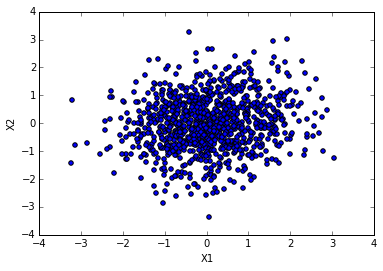

In [8]:
# Disegna il grafico di dispersione del dataset.
plt.figure()
plt.scatter(dataset[:, 0], dataset[:, 1])
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

## Analisi delle componenti principali

L'analisi delle componenti principali richiede che il dataset sia stato centrato rispetto alla media.

Ciò equivale a calcolare centered_dataset = dataset - np.mean(dataset, axis=0).

Si effettua, di seguito, tale operazione utilizzando Scikit-learn.

In [9]:
# Se si volesse normalizzare anche rispetto alla deviazione standard,
# bisognerebbe impostare il parametro with_std uguale a True.
from sklearn.preprocessing import StandardScaler
centered_dataset = StandardScaler(with_std=False).fit_transform(dataframe)

### Metodo 1: implementazione ed esecuzione della PCA mediante NumPy
Si effettua, di seguito, l'implementazione e l'esecuzione della PCA mediante NumPy.
L'implementazione è stata effettuata in due modi diversi:
- principal_component_analysis: effettua la PCA determinando e riordinando autovettori e autovalori della matrice di covarianza del dataset.
- principal_component_analysis_svd: effettua la PCA direttamente a partire dalla decomposizione ai valori singolari del dataset.

N.B.: il segno dei risultati può differire tra le diverse implementazioni della PCA, dato che esso dipende dal verso degli assi principali individuati.

È preferibile implementare la PCA mediante SVD in quanto in tale maniera non si deve effettuare il calcolo esplicito della matrice di covarianza, da cui possono derivare problemi di stabilità numerica. Una matrice che, sotto tale aspetto, risulta problematica è, ad esempio, la matrice di Läuchli.

In [10]:
def principal_component_analysis(dataset, k=None):
    """Effettua la PCA sulla matrice di covarianza di un dataset.

    Si assume che il dataset sia stato precedentemente centrato rispetto alla media.
    Se si volesse effettuare la PCA sulla matrice di correlazione del dataset,
    basterebbe normalizzare il dataset rispetto alla deviazione standard
    e poi applicare la PCA sulla matrice di covarianza di tale dataset.

    Args:
        dataset: matrice costituita sulle righe dai campioni e sulle colonne dalle feature.
        k: None se non si vuole troncare, altrimenti numero di componenti principali da considerare.

    Returns:
        principal_axes: matrice avente come colonne gli assi principali determinati dalla PCA.
        eigenvalues: autovalori determinati dalla PCA.

    """
    # Calcola la matrice di covarianza del dataset.
    cov_matrix = np.cov(dataset.T)

    # Calcola autovalori e autovettori del dataset.
    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

    # Ordina in modo decrescente le autocoppie rispetto ai loro autovalori.
    indexes = np.argsort(-eigenvalues)
    eigenvalues = eigenvalues[indexes]
    principal_axes = eigenvectors[:, indexes]

    # Effettua il troncamento se k è diverso da None.
    if k is not None:
        principal_axes = principal_axes[:, :k]

    # Restituisce la matrice degli assi principali e il vettore degli autovalori.
    return [principal_axes, eigenvalues]

def principal_component_analysis_svd(dataset, k=None):
    """Effettua la PCA sulla matrice di covarianza di un dataset mediante la SVD.

    Si assume che il dataset sia stato precedentemente centrato rispetto alla media.
    Se si volesse effettuare la PCA sulla matrice di correlazione del dataset,
    basterebbe normalizzare il dataset rispetto alla deviazione standard
    e poi applicare la PCA sulla matrice di covarianza di tale dataset.

    Args:
        dataset: matrice costituita sulle righe dai campioni e sulle colonne dalle feature.
        k: None se non si vuole troncare, altrimenti numero di componenti principali da considerare.

    Returns:
        principal_axes: matrice avente come colonne gli assi principali determinati dalla PCA.
        eigenvalues: autovalori determinati dalla PCA.

    """
    # Calcola la decomposizione ai valori singolari del dataset.
    U, S, V = np.linalg.svd(dataset, full_matrices=False)

    # Determina gli assi principali.
    principal_axes = V.T

    # Determina gli autovalori.
    eigenvalues = (S ** 2) / dataset.shape[0]

    # Restituisce la matrice degli assi principali e il vettore degli autovalori.
    return [principal_axes, eigenvalues]

def pca_projections(dataset, principal_axes):
    """Proietta un dataset sugli assi principali determinando le componenti principali.

    Args:
        dataset: matrice costituita sulle righe dai campioni e sulle colonne dalle feature.
        principal_axes: matrice avente come colonne gli assi principali determinati dalla PCA.

    Returns:
        pca_components: matrice avente come colonne le componenti principali determinate dalla PCA.

    """
    pca_components = dataset.dot(principal_axes)
    return pca_components

# Effettua la PCA sulla matrice di covarianza del dataset mediante la SVD.
principal_axes, eigenvalues = principal_component_analysis_svd(centered_dataset)
print("Matrice degli assi principali:\n", principal_axes)
print("\nAutovalori:\n", eigenvalues)

# Effettua la PCA sulla matrice di covarianza del dataset.
# principal_axes, eigenvalues = principal_component_analysis(centered_dataset)
# print("\nMatrice degli assi principali:\n", principal_axes)
# print("\nAutovalori:\n", eigenvalues)

Matrice degli assi principali:
 [[-0.81403676  0.58081335]
 [-0.58081335 -0.81403676]]

Autovalori:
 [ 1.13018834  0.83593594]


Si mostra, di seguito, un grafico di dispersione evidenziando gli assi principali determinati dalla PCA.

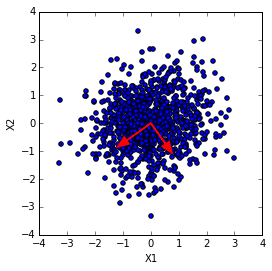

In [11]:
def draw_principal_axes(x1, x2, principal_axes, eigenvalues):
    """Disegna un grafico di dispersione evidenziando gli assi principali determinati dalla PCA.

    Args:
        x1: prima variabile da disegnare.
        x2: seconda variabile da disegnare.
        principal_axes: matrice avente come colonne gli assi principali determinati dalla PCA.
        eigenvalues: autovalori determinati dalla PCA.

    """
    fig, ax = plt.subplots()
    mu0 = np.mean(x1)
    mu1 = np.mean(x2)
    plt.scatter(x1, x2)
    axis0 = (principal_axes[:, 0]) * np.sqrt(eigenvalues[0])
    axis1 = (principal_axes[:, 1]) * np.sqrt(eigenvalues[1])
    plt.arrow(mu0, mu1, axis0[0], axis0[1], color='r', linewidth=1.5, head_width=0.3, head_length=0.4)
    plt.arrow(mu0, mu1, axis1[0], axis1[1], color='r', linewidth=1.5, head_width=0.3, head_length=0.4)
    ax.set_aspect('equal')
    ax.set_xlim([-4,4])
    ax.set_ylim([-4,4])
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.show()

draw_principal_axes(centered_dataset[:, 0], centered_dataset[:, 1], principal_axes, eigenvalues)

Si mostra, di seguito, uno screeplot degli autovalori determinati dalla PCA.

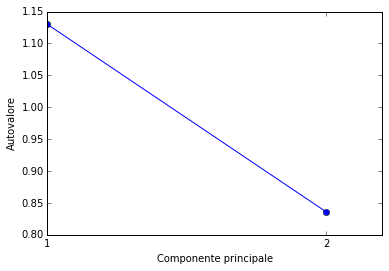

In [12]:
def draw_screeplot(eigenvalues, logarithm=False):
    """Disegna uno screeplot degli autovalori determinati dalla PCA.

    Args:
        eigenvalues: autovalori determinati dalla PCA.
        logarithm: True se si vuole uno screeplot logaritmico, False altrimenti.

    """
    plt.figure()
    indexes = np.arange(len(eigenvalues)) + 1
    if logarithm:
        plt.plot(indexes, np.log(eigenvalues), 'o-')
    else:
        plt.plot(indexes, eigenvalues, 'o-')
    plt.xlabel("Componente principale")
    plt.ylabel("Autovalore")
    plt.xticks(indexes)
    plt.show()

draw_screeplot(eigenvalues)

Si mostrano, di seguito, le varianze cumulative conservate dalle componenti principali ottenute con la PCA.

In [13]:
def cumulative_variances(eigenvalues):
    """Calcola le varianze cumulative conservate dalle componenti principali determinate dalla PCA.

    Args:
        eigenvalues: autovalori determinati dalla PCA.

    Returns:
        cumulative_vars: varianze cumulative conservate dalle componenti principali determinate dalla PCA.

    """
    cumulative_vars = np.cumsum(eigenvalues) / np.sum(eigenvalues)
    return cumulative_vars

cumulative_vars = cumulative_variances(eigenvalues)
for i, eigenvalue in enumerate(eigenvalues):
    print("Autovalore {0}\t\t{1}".format(i, eigenvalue))
    print("Varianza cumulativa:\t{0}\n".format(cumulative_vars[i]))

Autovalore 0		1.1301883389661855
Varianza cumulativa:	0.5748305703758346

Autovalore 1		0.8359359369700227
Varianza cumulativa:	1.0



Calcola le proiezioni del dataset rispetto ad entrambi gli assi principali, in quanto solo in tale maniera si ottiene un contenuto informativo accettabile. Dato che sono stati considerati due assi principali, tali proiezioni giacciono su un piano bidimensionale.

In [14]:
pca_components = pca_projections(centered_dataset, principal_axes)

print("\nProiezioni nel nuovo sottospazio vettoriale:\n{0}".format(pca_components))


Proiezioni nel nuovo sottospazio vettoriale:
[[-0.66219194  0.88273481]
 [-2.66081864  0.38355784]
 [ 0.11233118  0.38257632]
 [-1.23782742 -0.90870256]
 [ 0.87940174  0.59163929]
 [-0.55853258 -0.45293398]
 [-0.55023779 -0.78408664]
 [ 0.59875008  0.34776417]
 [ 0.92813656  0.17820751]
 [-1.49687606  0.29381839]
 ..., 
 [ 2.1549616  -0.19405604]
 [ 1.2581492  -1.03177172]
 [-2.57820159 -0.39713762]
 [-0.64711247 -1.01767831]
 [ 0.90046806  0.95098455]
 [-0.24275892 -1.26381879]
 [-0.78868941 -0.64612608]
 [-0.42438152  0.42470222]
 [-0.64072235 -1.00311583]
 [-0.38680014 -1.04149912]]


Si disegna, di seguito, un grafico di dispersione dei punti proiettati nel sottospazio individuato.

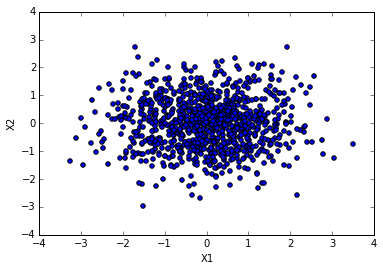

In [15]:
plt.figure()
plt.scatter(pca_components[:, 0], pca_components[:, 1])
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

Si mostra, di seguito, il cerchio di correlazione tra le feature e le componenti principali determinate dalla PCA.

Coefficienti di correlazione:
[[-0.85232672  0.52300972]
 [-0.63849822 -0.7696233 ]]


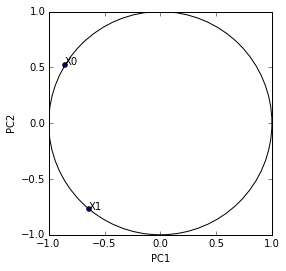

In [16]:
from scipy.stats import pearsonr

def pca_correlations(dataset, principal_component_1, principal_component_2):
    """Calcola le correlazioni tra le feature e le prime due componenti principali determinate dalla PCA.

    Args:
        dataset: matrice costituita sulle righe dai campioni e sulle colonne dalle feature.
        principal_component_1: prima componente principale determinata dalla PCA.
        principal_component_2: seconda componente principale determinata dalla PCA.

    Returns:
        correlations: matrice avente come righe le correlazioni relative a ciascuna feature.

    """
    correlations = []
    for feature in dataset.T:
        correlation_comp_1 = pearsonr(feature, principal_component_1)[0]
        correlation_comp_2 = pearsonr(feature, principal_component_2)[0]
        correlations.append([correlation_comp_1, correlation_comp_2])
    correlations = np.array(correlations)
    return correlations

def draw_correlation_circle(correlations):
    """Disegna il cerchio delle correlazioni a partire dalla matrice delle correlazioni specificata.

    Args:
        correlations:  matrice avente come righe le correlazioni relative a ciascuna feature.

    """
    fig, ax = plt.subplots()
    plt.scatter(correlations[:, 0], correlations[:, 1])
    for i, xy in enumerate(zip(correlations[:, 0], correlations[:, 1])):
        ax.annotate("X{0}".format(i), xy=xy) 
    circle = plt.Circle((0,0),1, facecolor='none')
    fig.gca().add_artist(circle)
    ax.set_aspect('equal')
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.show()

correlations = pca_correlations(centered_dataset, pca_components[:, 0], pca_components[:, 1])
print("Coefficienti di correlazione:\n{0}".format(correlations))
draw_correlation_circle(correlations)

### Metodo 2: esecuzione della PCA mediante Scikit-learn

Si effettua, di seguito, l'esecuzione della PCA mediante Scikit-learn. Si eseguono tutte le operazioni sul dataset centrato, per coerenza con il precedente metodo, anche se Scikit-learn centra automaticamente i dati rispetto alla loro media prima di effettuare la PCA.

In [17]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(centered_dataset)

print("Matrice degli assi principali:\n", pca.components_.T)
print("\nPercentuale di varianza cumulativa conservata dalle componenti:\n{0}"
      .format(np.cumsum(pca.explained_variance_ratio_)))

Matrice degli assi principali:
 [[-0.81403676  0.58081335]
 [-0.58081335 -0.81403676]]

Percentuale di varianza cumulativa conservata dalle componenti:
[ 0.57483057  1.        ]


La classe PCA di Scikit-learn non restituisce lo spettro della matrice di covarianza del dataset specificato.
Calcoliamo, pertanto, gli autovalori di tale matrice partendo dalle percentuali di varianza già valutate. Tali autovalori saranno già ordinati in modo decrescente perché i valori di partenza lo erano.

In [18]:
sk_eigenvalues = pca.explained_variance_ratio_ * np.trace(np.cov(centered_dataset.T))
print("Autovalori della matrice di covarianza:\n", sk_eigenvalues)

Autovalori della matrice di covarianza:
 [ 1.13131966  0.83677271]


Si mostra, di seguito, uno screeplot degli autovalori determinati dalla PCA. Ciò è fatto richiamando l'apposita funzione definita precedentemente.

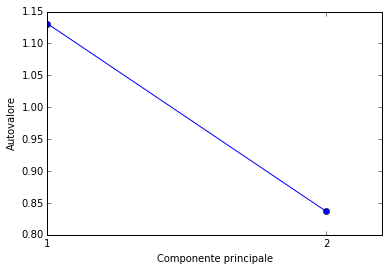

In [19]:
draw_screeplot(sk_eigenvalues)

Sono necessarie entrambe le componenti principali per ottenere un contenuto informativo accettabile, pertanto calcoliamo tali componenti principali considerando entrambi gli assi principali.

In [20]:
sk_projections = pca.fit_transform(centered_dataset)
print("Proiezioni:\n{0}".format(sk_projections))

Proiezioni:
[[-0.66219194  0.88273481]
 [-2.66081864  0.38355784]
 [ 0.11233118  0.38257632]
 [-1.23782742 -0.90870256]
 [ 0.87940174  0.59163929]
 [-0.55853258 -0.45293398]
 [-0.55023779 -0.78408664]
 [ 0.59875008  0.34776417]
 [ 0.92813656  0.17820751]
 [-1.49687606  0.29381839]
 ..., 
 [ 2.1549616  -0.19405604]
 [ 1.2581492  -1.03177172]
 [-2.57820159 -0.39713762]
 [-0.64711247 -1.01767831]
 [ 0.90046806  0.95098455]
 [-0.24275892 -1.26381879]
 [-0.78868941 -0.64612608]
 [-0.42438152  0.42470222]
 [-0.64072235 -1.00311583]
 [-0.38680014 -1.04149912]]
